In [1]:
import wrangle

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import env
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression,LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error,explained_variance_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
#import acquire
import modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
zillow_train,zillow_validate,zillow_test=wrangle.wrangled_file()

In [3]:
zillow_train.shape,zillow_validate.shape,zillow_test.shape

((25350, 30), (10787, 30), (8923, 30))

In [4]:
#use function to scale features and concat them back to dataframe
scaled_train,scaled_validate,scaled_test = modeling.scale_data(zillow_train,zillow_validate,zillow_test,cols=['bedroom','bathroom','age','month','taxrate'])

In [5]:
scaled_train.head(1)

,bathroom,bedroom,calculatedbathnbr,sqtft,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lots,...,propertylandusedesc,county,taxrate,month,age,bedroom_scaled,bathroom_scaled,age_scaled,month_scaled,taxrate_scaled
0,3.0,3.0,3.0,1882.0,1882.0,6037.0,3.0,33890566.0,-118154278.0,15090.0,...,Condominium,"Los Angeles County, CA",0.013491,5,30.0,0.0,1.0,-0.909091,0.0,0.548855


In [6]:
scaled_train.columns

Index(['bathroom', 'bedroom', 'calculatedbathnbr', 'sqtft',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lots', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'zipcode', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvalue', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'heatingorsystemdesc', 'propertylandusedesc', 'county', 'taxrate',
       'month', 'age', 'bedroom_scaled', 'bathroom_scaled', 'age_scaled',
       'month_scaled', 'taxrate_scaled'],
      dtype='object')

In [7]:
features = ['bathroom', 'bedroom', 'calculatedbathnbr', 'sqtft','finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lots', 'rawcensustractandblock', 'zipcode', 'roomcnt', 'unitcnt',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvalue', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'taxrate',
       'month', 'age', 'bedroom_scaled', 'bathroom_scaled', 'age_scaled', 'month_scaled', 'taxrate_scaled']
target = ["logerror"]
X_train = scaled_train[features]
y_train = scaled_train[target]
X_validate = scaled_validate[features]
y_validate = scaled_validate[target]
X_test = scaled_test[features]
y_test = scaled_test[target]

In [8]:
X_train.head(1)

,bathroom,bedroom,calculatedbathnbr,sqtft,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lots,...,taxamount,censustractandblock,taxrate,month,age,bedroom_scaled,bathroom_scaled,age_scaled,month_scaled,taxrate_scaled
0,3.0,3.0,3.0,1882.0,1882.0,6037.0,3.0,33890566.0,-118154278.0,15090.0,...,2526.0,6.037554e+13,0.013491,5,30.0,0.0,1.0,-0.909091,0.0,0.548855


In [9]:
y_train.head(1)

,logerror
0,0.112968


In [10]:
#apply baseline value to train and validate
y_train["baseline_mean"] = y_train.logerror.mean()
y_train["baseline_median"] =y_train.logerror.median()
y_validate["baseline_mean"] = y_validate.logerror.mean()
y_validate["baseline_median"] =y_validate.logerror.median()

In [11]:

#calculate rmse using actual and baseline mean
def get_baseline(y_train,y_validate):
    RMSE_train_mean=mean_squared_error(y_train.logerror,y_train.baseline_mean, squared = False)
    RMSE_validate_mean=mean_squared_error(y_validate.logerror,y_validate.baseline_mean, squared = False)

    print("RMSE using Mean on \nTrain: ", round(RMSE_train_mean,8), "\nValidate: ", round(RMSE_validate_mean,8))
    print()

#calculate rmse using actual and baseline mean
    RMSE_train_median= mean_squared_error(y_train.logerror,y_train.baseline_median, squared = False)
    RMSE_validate_median= mean_squared_error(y_validate.logerror,y_validate.baseline_median, squared = False)

    print("RMSE using Median on \nTrain: ", round(RMSE_train_median,8), "\nValidate: ", round(RMSE_validate_median,8))


In [12]:
get_baseline(y_train,y_validate)

RMSE using Mean on 
Train:  0.15001528 
Validate:  0.16261366

RMSE using Median on 
Train:  0.15016435 
Validate:  0.16295375


    since rmse using mean is smaller, we use mean for baseline rmse

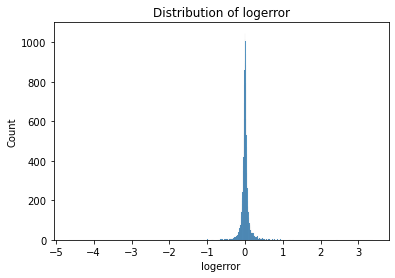

In [13]:
# peek at the distribution of my target varaible
sns.histplot(y_train.logerror)
plt.title('Distribution of logerror')
plt.show()

### Linear regression

In [14]:
def linear_regression(X_train,y_train,X_validate,y_validate):

    # create the model object
    lm = LinearRegression(normalize = True)
    
    # Fit the model
    lm.fit(X_train, y_train.logerror)
    
    # Predict y on train
    y_train['logerror_pred_lm'] = lm.predict(X_train)
    # predict validate
    y_validate['logerror_pred_lm'] = lm.predict(X_validate)
    
    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

    print("RMSE for OLS using LinearRegression\nTraining/In-Sample", round(rmse_train, 8), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate, 8))

In [15]:
linear_regression(X_train,y_train,X_validate,y_validate)

RMSE for OLS using LinearRegression
Training/In-Sample 0.81932061 
Validation/Out-of-Sample:  0.82692463


### Lasso_lars

In [16]:
def lasso_lars(X_train, y_train, X_validate, y_validate, alpha):
    
    # create the model object
    lars = LassoLars(alpha)

    # fit the model.
    lars.fit(X_train, y_train.logerror)

    # predict train
    y_train['logerror_pred_lars'] = lars.predict(X_train)
    # predict validate
    y_validate['logerror_pred_lars'] = lars.predict(X_validate)
    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

    print("RMSE for Lasso + Lars, alpha = ", i, "\nTraining/In-Sample: ", round(rmse_train, 8), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate, 8))

In [17]:
for i in range(0,5):
    lasso_lars(X_train, y_train, X_validate, y_validate, alpha = i)
    print()

RMSE for Lasso + Lars, alpha =  0 
Training/In-Sample:  0.14969612 
Validation/Out-of-Sample:  0.16224802

RMSE for Lasso + Lars, alpha =  1 
Training/In-Sample:  0.15001528 
Validation/Out-of-Sample:  0.16268363

RMSE for Lasso + Lars, alpha =  2 
Training/In-Sample:  0.15001528 
Validation/Out-of-Sample:  0.16268363

RMSE for Lasso + Lars, alpha =  3 
Training/In-Sample:  0.15001528 
Validation/Out-of-Sample:  0.16268363

RMSE for Lasso + Lars, alpha =  4 
Training/In-Sample:  0.15001528 
Validation/Out-of-Sample:  0.16268363



#### GLM

In [18]:
def Tweedie_regressor(X_train, y_train, X_validate, y_validate, power, alpha):

    # create the model object
    glm = TweedieRegressor(power=power, alpha=alpha)

    # fit the model to our training data.
    glm.fit(X_train, y_train.logerror)

    # predict train
    y_train['logerror_pred_glm'] = glm.predict(X_train)
    # predict validate
    y_validate['logerror_pred_glm'] = glm.predict(X_validate)
    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)
    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

    print("RMSE for GLM using Tweedie, power=", power, " & alpha=", alpha, 
        "\nTraining/In-Sample: ", round(rmse_train, 8), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate, 8))

In [19]:
Tweedie_regressor(X_train, y_train, X_validate, y_validate, power = 0, alpha=1)


RMSE for GLM using Tweedie, power= 0  & alpha= 1 
Training/In-Sample:  0.15001528 
Validation/Out-of-Sample:  0.16268363


In [20]:
Tweedie_regressor(X_train, y_train, X_validate, y_validate, power = 0, alpha = 0)

RMSE for GLM using Tweedie, power= 0  & alpha= 0 
Training/In-Sample:  0.15001528 
Validation/Out-of-Sample:  0.16268363


### Polynomial Regression

In [21]:
def polynomial_regression(X_train, y_train, X_validate, y_validate, degree):
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree= degree)
    
    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train)
    

    # transform X_validate_scaled 
    X_validate_degree2 = pf.transform(X_validate)

    # create the model object
    lm2 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2.fit(X_train_degree2, y_train.logerror)

    # predict train
    y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

    # evaluate: train rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

    # predict validate
    y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

    # evaluate: validate rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

    print("RMSE for Polynomial Model, degrees=", degree, "\nTraining/In-Sample: ", round(rmse_train,8), 
        "\nValidation/Out-of-Sample: ", round(rmse_validate,8))

In [22]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree = 1)

RMSE for Polynomial Model, degrees= 1 
Training/In-Sample:  6.50262099 
Validation/Out-of-Sample:  6.46206521


In [23]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree = 2)

RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  2.7127199 
Validation/Out-of-Sample:  345083755.443444


In [24]:
polynomial_regression(X_train, y_train, X_validate, y_validate, degree = 3)

RMSE for Polynomial Model, degrees= 3 
Training/In-Sample:  1684.24418702 
Validation/Out-of-Sample:  174987412.51873323


    Best model is Polynomial regression, degree 2
    We will use this model in our unseen sample to predict logerror

In [25]:
def test_prediction(X_test,y_test):

    lm5 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm5.fit(X_test, y_test.logerror)

     # predict test
    y_test['logerror_pred_lm5'] = lm5.predict(X_test)

    # evaluate: test rmse
    rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm5)**(1/2)

    print("RMSE for Linear Regression Model,","\ntest: ", rmse_test, "\nr^2: ", explained_variance_score(y_test.logerror,
                                           y_test.logerror_pred_lm5))

In [26]:
#test predict

test_prediction(X_test,y_test)

RMSE for Linear Regression Model, 
test:  0.16559978195775346 
r^2:  -0.05016667313628087
